In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

import pickle

import numpy as np
import pandas as pd

pd.options.display.float_format = "{:.5f}".format

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import PIL
from pillow_heif import register_heif_opener

register_heif_opener()

In [2]:
CWD = os.getcwd()
SAVE_PATH = os.path.join(os.path.dirname(CWD), "data")
DF_PATH = os.path.join(SAVE_PATH, "df_2024_09_28_20_49_33.parquet.gzip")

In [3]:
from py8tb import preprocessing_pipeline

# Análisis y preprocesamiento de df

In [4]:
df = preprocessing_pipeline(path=DF_PATH)

In [5]:
file_size_and_counter_by_type = (
    df.groupby(["FileExtension", "FileType"])
    .agg(
        NrFiles=("FilePath", len),
        TotalSizeMB=("SizeMB", np.sum),
        TotalSizeGB=("SizeMB", lambda series: np.sum(series) / (1024)),  # GB
    )
    .reset_index()
    .assign(
        NrFilesByType=lambda df: df.groupby("FileType")["NrFiles"].transform(np.sum),
        TotalSizeMBByType=lambda df: df.groupby("FileType")["TotalSizeMB"].transform(
            np.sum
        ),
        PctNrFilesByType=lambda df: df["NrFiles"] / df["NrFilesByType"],
        PctSizeMBByType=lambda df: df["TotalSizeMB"] / df["TotalSizeMBByType"],
    )
    .query("FileType == 'video' or FileType == 'photo'")
    .sort_values("FileType", ascending=False)
)

file_size_and_counter_by_type

,FileExtension,FileType,NrFiles,TotalSizeMB,TotalSizeGB,NrFilesByType,TotalSizeMBByType,PctNrFilesByType,PctSizeMBByType
3,.mp4,video,24,3916.49690,3.82470,24,3916.49690,1.00000,1.00000
1,.heic,photo,10,15.11057,0.01476,36,62.09991,0.27778,0.24333
2,.jpg,photo,24,46.26830,0.04518,36,62.09991,0.66667,0.74506
4,.png,photo,2,0.72104,0.00070,36,62.09991,0.05556,0.01161


In [6]:
photos = df[df["FileType"] == "photo"]

In [7]:
photos.head()

,FilePath,CreationDate,LastModificationDate,SizeMB,Sha256,FileName,FileExtension,FileType
5,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:26,2.04483,0280e5574bf8a0b0d737e40f2a3775bc09420e18450752...,IMG_20220804_222534.jpg,.jpg,photo
6,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:30,1.76766,b204d2e87bcf61ab3ca32464bf74cab213fbb1204898dc...,IMG_20220804_215414.jpg,.jpg,photo
7,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:30,1.89978,d6ce316634e919fe8f1c2fbf1b2d164d5d1c0f5512419c...,IMG_20220804_210356.jpg,.jpg,photo
9,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:28,1.39509,f43566fed269b114d301ccf73676ab14a4c8b9c5762fd9...,IMG_20220804_213950.jpg,.jpg,photo
10,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:31,2.22810,e55a88f92ea2b20db5c0284314b68642c53dffda2aca3d...,IMG_20220804_210844.jpg,.jpg,photo


In [8]:
SHA = (
    photos
    # .pipe(lambda df: df[df["FileExtension"] == ".heic"])
    ["Sha256"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"})
    .pipe(lambda df: df[df["Count"] >= 2])
    .sample(1)["Sha256"]
    .iloc[0]
)

In [9]:
SHA

'd6ce316634e919fe8f1c2fbf1b2d164d5d1c0f5512419c6d4703faca26921079'

In [10]:
def get_matplotlib_figure_params(paths: list[str]) -> tuple[int, int]:
    if (len(paths) % 3) == 0:
        return (int(len(paths) / 3), 3)
    elif (len(paths) % 2) == 0:
        return (int(len(paths) / 2), 2)
    else:
        return (int(len(paths) / 2) + 1, 2)

In [11]:
def plot_duplicated_photos(sha: str, photos: pd.DataFrame) -> None:

    # get the path to plot/show images
    paths = photos[photos["Sha256"].str.contains(sha)]["FilePath"].tolist()
    nr_rows, nr_columns = get_matplotlib_figure_params(paths=paths)

    # plotting with matplotlib
    fig = plt.figure(figsize=(15, 5))
    axes = fig.subplots(nr_rows, nr_columns).flatten()

    for path, ax in zip(paths, axes):
        ax.imshow(PIL.Image.open(path))

In [12]:
photos[photos["Sha256"].str.contains(SHA)]

,FilePath,CreationDate,LastModificationDate,SizeMB,Sha256,FileName,FileExtension,FileType
7,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:37,2022-08-05 17:43:30,1.89978,d6ce316634e919fe8f1c2fbf1b2d164d5d1c0f5512419c...,IMG_20220804_210356.jpg,.jpg,photo
47,/Users/nicolaepopescul/Desktop/code/streams/20...,2024-09-28 19:46:19,2022-08-05 17:43:30,1.89978,d6ce316634e919fe8f1c2fbf1b2d164d5d1c0f5512419c...,IMG_20220804_210356.jpg,.jpg,photo


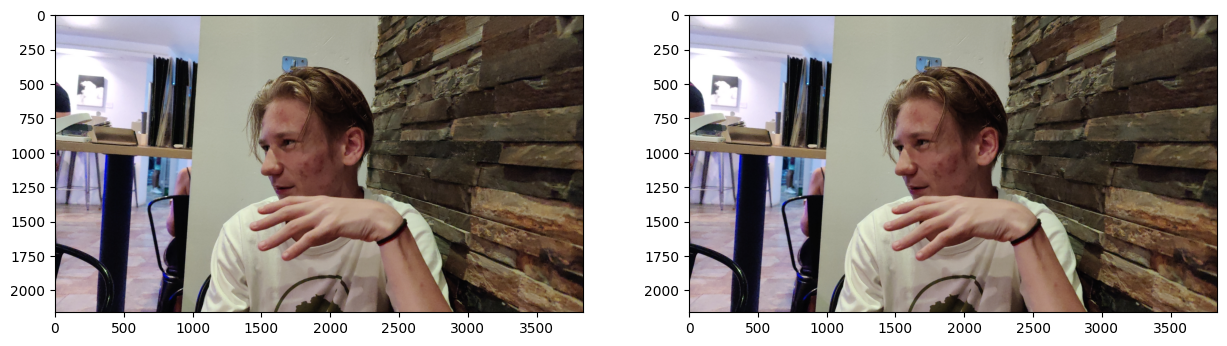

In [13]:
plot_duplicated_photos(sha=SHA, photos=photos)

In [14]:
total_photos = photos["FileType"].value_counts().iloc[0]

In [15]:
unique_photos = photos.groupby(["Sha256"]).size().size

In [16]:
duplicates_photos = total_photos - unique_photos

In [17]:
duplicates_photos

18

In [18]:
sha256_list = photos["Sha256"].values.tolist()
path_list = photos["FilePath"].values.tolist()

In [19]:
# %%timeit

dict_sha256_to_save = {}
dict_sha256_to_delete = {}

for sha256_, path_ in zip(sha256_list, path_list):
    if sha256_ not in dict_sha256_to_save.keys():
        dict_sha256_to_save[sha256_] = path_
    else:
        dict_sha256_to_delete[path_] = sha256_

In [20]:
len(dict_sha256_to_save)

18

In [21]:
len(dict_sha256_to_delete)

18